## Kaggle Titanic

### Feat7/wip
Branced from EDA1 for feature engineering based on knowledge obtained from EDA
- Assign age to NaN values based on initials
- Assign S to NaN values
- Dropped Cabin,name and passengerID

In [92]:
%%bash
git checkout 'feat6/wip'
git fetch

error: Your local changes to the following files would be overwritten by checkout:
	Titanic.ipynb
Please commit your changes or stash them before you switch branches.
Aborting


In [90]:
%%bash
git add 'Titanic.ipynb'
git commit -m 'Modified code to drop name and cabin feature'
git push --set-upstream origin 'feat7(EDA1)/wip'

[feat7(EDA1)/wip 8f536f1] Modified code to drop name and cabin feature
 1 file changed, 111 insertions(+), 91 deletions(-)
Branch feat7(EDA1)/wip set up to track remote branch feat7(EDA1)/wip from origin.


To github.com:Theerit/Kaggle_Titanic.git
   2ddbd78..8f536f1  feat7(EDA1)/wip -> feat7(EDA1)/wip


As usual, import all neccasary stuff into the notebook

In [44]:
%matplotlib inline 
import requests 
import StringIO
import zipfile
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 

# If this module is not already installed, you may need to install it. 
# You can do this by typing 'pip install seaborn' in the command line
import seaborn as sns 

import sklearn.model_selection

First, I will start by loading the data in panda dataframe and do some EDA.

In [45]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
#Concate train and test to avoid mismatch features in the testing phase
train_objs_num = len(train)
dataset = pd.concat(objs=[train, test], axis=0)
#dataset = pd.get_dummies(dataset)
#train = dataset.copy(dataset[:train_objs_num])
train = dataset[:train_objs_num].copy()
#test = dataset.copy(dataset[train_objs_num:])
test = dataset[train_objs_num:].copy()
print(train.shape)

(891, 12)


Take a peek look at raw data table.

In [46]:
train.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


It appears that the test data has no label(answer class) and seems to serve submission function. Cross validation and model evaluation will be done based on the data provided in Train.csv file only. Next, split dataframe into X and Y dataframe where X store the data while Y store the label.

In [82]:
X = train.copy()
#X = X.drop('Survived',axis=1)
X_plot = train.copy()
X = X.drop('PassengerId',axis=1)  # Shouldn't relate to survival chance
X = X.drop('Cabin',axis=1)
X = X.drop('Name',axis=1)
Y = pd.DataFrame(train['Survived'])

In [83]:
Y[Y['Survived']==1].count()

Survived    342
dtype: int64

### Extract age from name

Extract some useful information from name, to convert the information to age. Take a look at mean age then assign person who doesn't have age (Nan value in Age) the mean value according to their initials

In [84]:
X_plot['Initial']=0
for i in X_plot:
    X_plot['Initial']=X_plot.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
#X_plot['Initial'].value_counts()

#Change data in X also (since its the real training data)
X['Initial']=0
for i in X:
    X['Initial']=X.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations

pd.crosstab(X_plot.Initial,X_plot.Sex).T.style.background_gradient(cmap='summer_r')

/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  app.launch_new_instance()
/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


Replace some of the initials with appropriate initials (for more accurate age assign)

In [85]:
X['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

In [86]:
# Take a lot at mean age of Mr vs Miss Master
print('Mean age of Mr:',X_plot[X_plot['Initial']=="Mr"]['Age'].mean())
print('Mean age of Miss:',X_plot[X_plot['Initial']=="Miss"]['Age'].mean())
print('Mean age of Mrs:',X_plot[X_plot['Initial']=="Mrs"]['Age'].mean())
print('Mean age of Master:',X_plot[X_plot['Initial']=="Master"]['Age'].mean())
others = ['Mr','Miss','Mrs','Master']
print('Mean age of others:',X_plot[~X_plot['Initial'].isin(others)]['Age'].mean())

('Mean age of Mr:', 32.368090452261306)
('Mean age of Miss:', 21.773972602739725)
('Mean age of Mrs:', 35.898148148148145)
('Mean age of Master:', 4.5741666666666667)
('Mean age of others:', 42.384615384615387)


In [87]:
X['Age'][(X['Initial']=='Mr') & (X['Age'].isnull())] = X[X['Initial']=='Mr']['Age'].mean()
X['Age'][(X['Initial']=='Miss') & (X['Age'].isnull())] = X[X['Initial']=='Miss']['Age'].mean()
X['Age'][(X['Initial']=='Mrs') & (X['Age'].isnull())] = X[X['Initial']=='Mrs']['Age'].mean()
X['Age'][(X['Initial']=='Master') & (X['Age'].isnull())] = X[X['Initial']=='Master']['Age'].mean()
X['Age'][(X['Initial']=='other') & (X['Age'].isnull())] = X[X['Initial']=='other']['Age'].mean()

/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [88]:
X['Age'].isnull().any()

False

Assign "S" to Nan values

In [89]:
X['Embarked'].fillna("S",inplace=True)
X['Embarked'].isnull().any()

False

### Dummy Variables
For starter, create dummy variables for categorical features.

In [ ]:
cat_attri = ['']

In [77]:
for column in (cat_attri):
    #Lets just keep every categorical attributes for plotting
    tempDF = pd.get_dummies(X[column],prefix=column)
    X.drop(column,axis=1,inplace=True)
    X = X.join(tempDF)
for column in (cat_attri): #Create dummy for test
    #Lets just keep every categorical attributes for plotting
    tempDF = pd.get_dummies(test[column],prefix=column)
    test.drop(column,axis=1,inplace=True)
    test = test.join(tempDF)

### Feature Evaluation
For starter using random forest to evaluate feature importance.
Code shamelessly brought from:http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [78]:
#Format dataframe for scikit training
y = X['Survived']
X.drop('Survived',axis=1,inplace=True)

Start with numerical feature ranking first

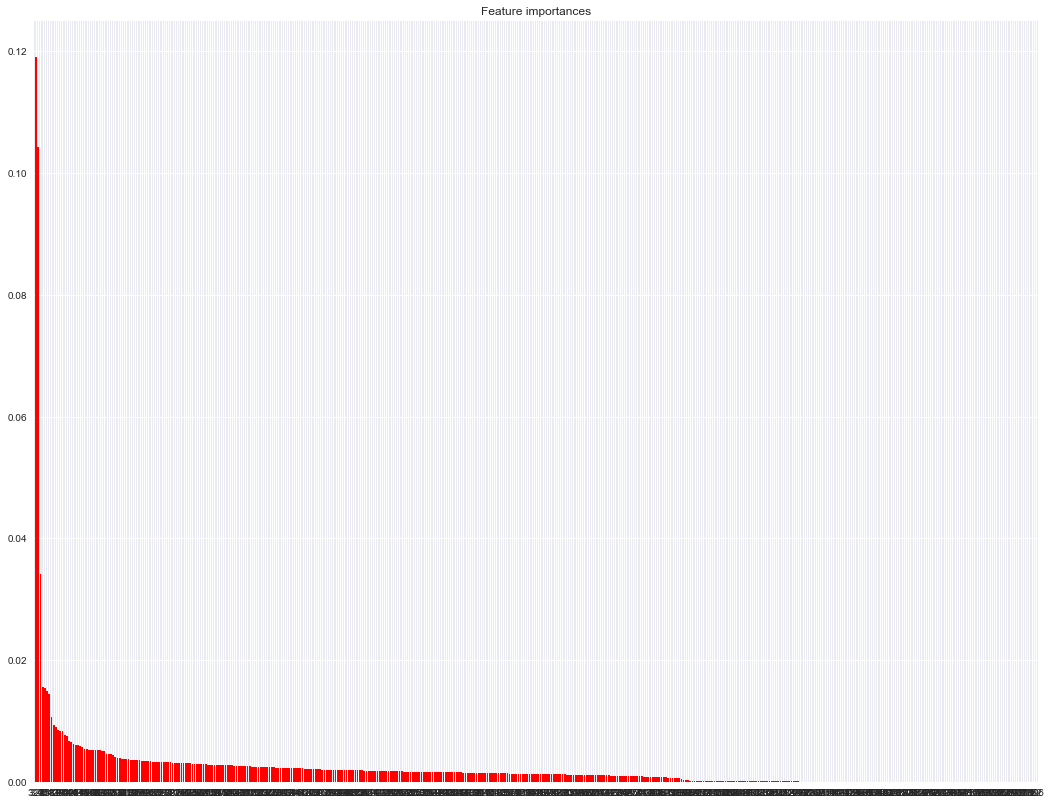

In [79]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using 3 informative features
#X, y = make_classification(n_samples=1000,
#                           n_features=10,
#                          n_informative=3,
#                           n_redundant=0,
#                           n_repeated=0,
#                           n_classes=2,
#                           random_state=0,
#                           shuffle=False)

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
#print("Feature ranking:")

#for f in range(X.shape[1]):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(18,14))
plt.title("Feature importances")
#plt.bar(range(X.shape[1]), importances[indices],
#       color="r", yerr=std[indices], align="center")

plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")

plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

### Model Training
For the sake of early versions use all features for learning. Use 5 fold CV grid search (with 1 fold labelled test set and will not be the part of parameter tuning)

First split into 4:1 train/CV and test dataset

In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
import xgboost as xgb
from sklearn.grid_search import GridSearchCV

clf = xgb.XGBClassifier(
        nthread = 1,
        silent = 1,
        )
# specify parameters via map
parameters = {'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [5,6,7,8],
              'subsample': [0.2,0.4,0.6,0.8],
              'colsample_bytree': [0.6,0.7,0.8]}
xgb_model = xgb.XGBClassifier()
clf = GridSearchCV(xgb_model, parameters, n_jobs=1, 
                   cv=4, 
                   scoring='roc_auc',
                   verbose=2, refit=False)
clf.fit(X_train,y_train)
best_param_4CV = clf.best_params_

/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/theerit/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Fitting 4 folds for each of 48 candidates, totalling 192 fits
[CV] objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 
[CV]  objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 -   0.3s
[CV] objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 
[CV]  objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 -   0.1s
[CV] objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 -   0.2s
[CV] objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 
[CV]  objective=binary:logistic, subsample=0.2, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 -   0.1s
[CV] objective=binary:logistic, subsample=0.4, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 
[CV]  objective=binary:logistic, subsample=0.4, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 -   0.2s
[CV] objective=binary:logistic, subsample=0.4, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 
[CV]  objective=binary:logistic, subsample=0.4, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 -   0.3s
[CV] objective=binary:logistic, subsample=0.4, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 
[CV]  objective=binary:logistic, subsample=0.4, learning_rate=0.05, colsample_bytree=0.6, max_depth=5 -   0.2s
[CV] objective=binary:logistic, subsa

[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:   41.7s finished


Performance on the 4thCV fold

In [82]:
print('Best AUC score:'+str(clf.best_score_))
print('Best Param:' +str(clf.best_params_))

Best AUC score:0.832411789124
Best Param:{'objective': 'binary:logistic', 'subsample': 0.6, 'learning_rate': 0.05, 'colsample_bytree': 0.7, 'max_depth': 5}


Now check performance on accuracy basis.

In [83]:
clf2 = xgb.XGBClassifier(
        nthread = 1,
        silent = 1,
        colsample_bytree = best_param_4CV['colsample_bytree'],
        learning_rate = best_param_4CV['learning_rate'],
        max_depth =  best_param_4CV['max_depth'],
        objective = best_param_4CV['objective'],
        subsample = best_param_4CV['subsample']
        )
clf2.fit(X_train,y_train)
from sklearn.metrics import accuracy_score
print('Accuracy:'+str(accuracy_score(y_train,clf2.predict(X_train))))

Accuracy:0.917808219178


In [86]:
import pickle
# save the model to disk
filename = 'master.sav'
pickle.dump(clf2, open(filename, 'wb'))

Now check performance on the test set.

In [84]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
print('Test set AUC score:'+str(roc_auc_score(y_test,clf2.predict(X_test))))
print('Test set Accuracy:'+str(accuracy_score(y_test,clf2.predict(X_test))))

Test set AUC score:0.67701863354
Test set Accuracy:0.702702702703
